In [1]:
import numpy as np
import time
import pandas as pd
from typing import Union
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay

In [2]:
from ambientfisher.interpolators import AmbientFisherInterpolator

In [3]:
def lognormal_family(alpha):
    mu = alpha[0]
    sigma = alpha[1] + 1.0
    def pdf(x):
        return np.exp(-(np.log(x) - mu)**2 / (2.0 * sigma**2)) / (np.sqrt(2*np.pi) * x * sigma)
    return pdf

xarray = np.linspace(1e-9, 7.0, num=10000)

In [4]:
def plot_anchor_interp(
    alpha_target=np.array([0.05, -0.25]),
    alpha_anchors=np.array([[0.0, 0.0], [0.1, -0.5], [0.0, -0.3]]),
    compare_predictions_with_truth = False,
    plot_simplex = False
):
    
    anchor_alphas = np.array(alpha_anchors)
    anchor_pdfs = [lognormal_family(alpha) for alpha in anchor_alphas]

    interp = AmbientFisherInterpolator(anchor_alphas, anchor_pdfs, xarray, plot_simplex=plot_simplex)

    if plot_simplex: return None
        
    p_hat_kyle = interp.predict_extrinsic(alpha_target)
    p_hat_intrinsic = interp.predict_intrinsic(alpha_target)
    
    p_true = lognormal_family(alpha_target)(xarray)

    p0, p1, p2 = anchor_pdfs

    plt.figure(figsize=(7.2, 4.6))

    if not compare_predictions_with_truth:
        plt.plot(xarray, p0(xarray), c="black", label='anchor 1')
        plt.plot(xarray, p1(xarray), c="r", label='anchor 2')
        plt.plot(xarray, p2(xarray), c="g", label='anchor 3')
        plt.plot(xarray, p_hat_kyle, c="b", ls="dashed", label='target pred')
        plt.plot(xarray, p_true, c="b", ls="dotted", label='target truth')

    else:
        plt.plot(xarray, p_hat_kyle, label='Method Kyle')
        plt.plot(xarray, p_hat_intrinsic, label='Method Intrinsic')
        plt.plot(xarray, p_true, c="b", ls="dotted", label='target truth')
        
    plt.xlabel(r"$f(x \mid \alpha)$", fontsize=16)
    plt.ylabel("density", fontsize=14)

    plt.axis(xmin = 0.0, xmax = 5.0, ymin = 0.0, ymax = 0.9)

    plt.tight_layout()
    plt.legend()
    plt.show()

    return None


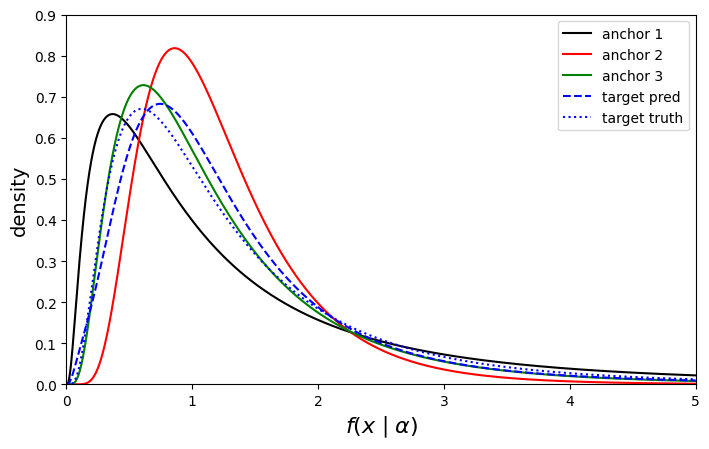

In [5]:
plot_anchor_interp(
    alpha_target=np.array([0.05, -0.25]),
    alpha_anchors=np.array([[0.0, 0.0], [0.1, -0.5], [0.0, -0.3]])
)

Test Predictions vs Truth
---

Try out the interpolation for various values of alpha located within the simplex

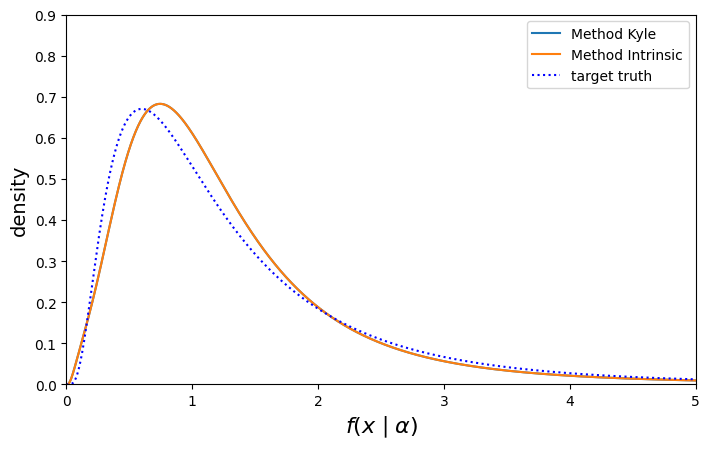

In [6]:
# Smack in the center of the simplex - works great with original AF

alpha_anchors = np.array([[0.0, 0.0], [0.1, -0.5], [0.0, -0.3]])
plot_anchor_interp(
    alpha_target=np.array([0.05, -0.25]),
    alpha_anchors=alpha_anchors,
    compare_predictions_with_truth = True
)

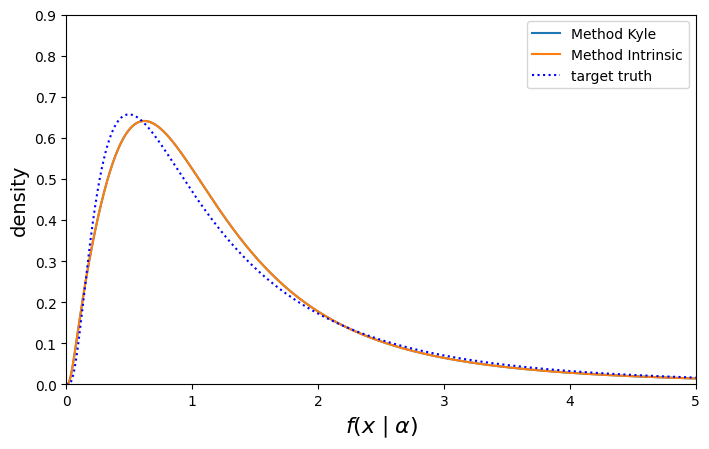

In [7]:
alpha_anchors = np.array([[0.0, 0.0], [0.1, -0.5], [0.0, -0.3]])
plot_anchor_interp(
    alpha_target=np.array([0.025, -0.15]),
    alpha_anchors=alpha_anchors,
    compare_predictions_with_truth = True
)

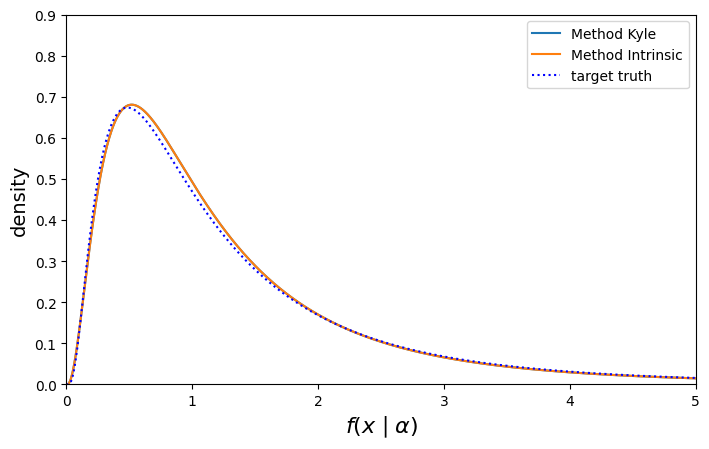

In [8]:
# Interpolation along one of the edges of the simplex - identical performance

alpha_anchors = np.array([[0.0, 0.0], [0.1, -0.5], [0.0, -0.3]])
plot_anchor_interp(
    alpha_target=np.array([0.0, -0.15]),
    alpha_anchors=alpha_anchors,
    compare_predictions_with_truth = True
)

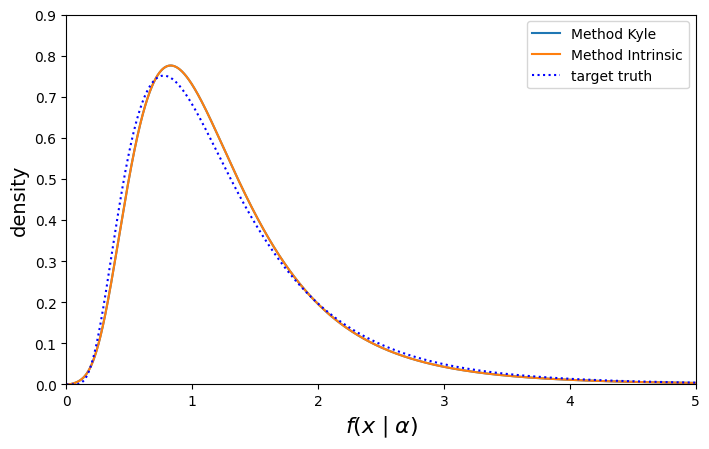

In [9]:
# Near the edge of the right-most vertex in the simplex - original AF starts to break down

alpha_anchors = np.array([[0.0, 0.0], [0.1, -0.5], [0.0, -0.3]])
plot_anchor_interp(
    alpha_target=np.array([0.08, -0.42]),
    alpha_anchors=alpha_anchors,
    compare_predictions_with_truth = True
)

Testing the performance at basis points
--


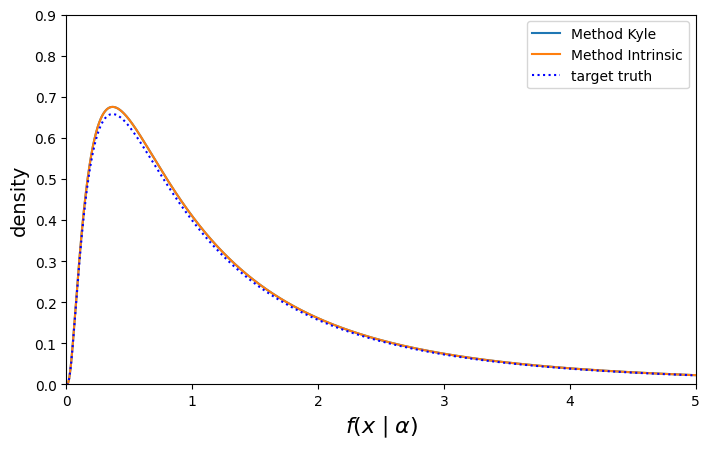

In [10]:
alpha_anchors = np.array([[0.0, 0.0], [0.1, -0.5], [0.0, -0.3]])
plot_anchor_interp(
    alpha_target=np.array(alpha_anchors[0]),
    alpha_anchors=alpha_anchors,
    compare_predictions_with_truth = True
)

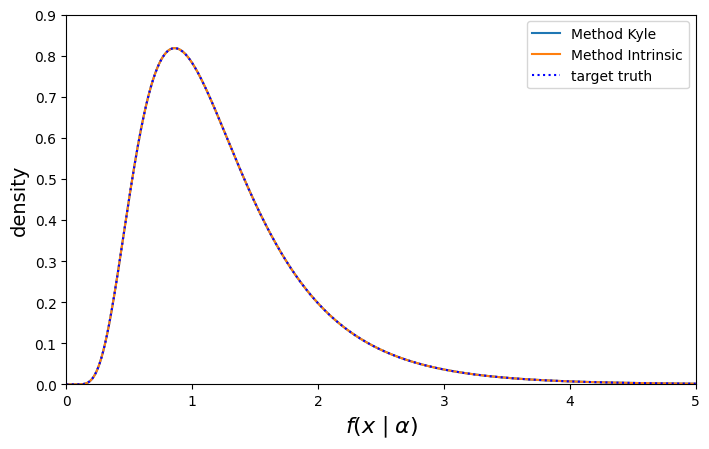

In [11]:
alpha_anchors = np.array([[0.0, 0.0], [0.1, -0.5], [0.0, -0.3]])
plot_anchor_interp(
    alpha_target=np.array(alpha_anchors[1]),
    alpha_anchors=alpha_anchors,
    compare_predictions_with_truth = True
)

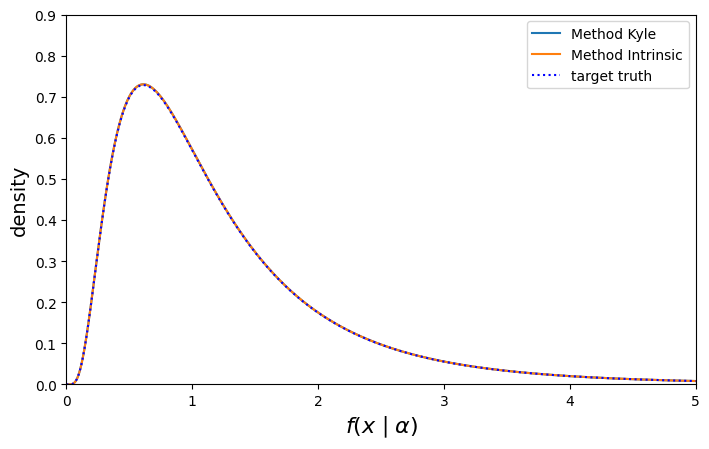

In [12]:
alpha_anchors = np.array([[0.0, 0.0], [0.1, -0.5], [0.0, -0.3]])
plot_anchor_interp(
    alpha_target=np.array(alpha_anchors[2]),
    alpha_anchors=alpha_anchors,
    compare_predictions_with_truth = True
)

Time Efficieny Tests
==

In [13]:
alpha_anchors = np.array([[0.0, 0.0], [0.1, -0.5], [0.0, -0.3]])
alpha_target=np.array([0.05, -0.25])

anchor_alphas = np.array(alpha_anchors)
anchor_pdfs = [lognormal_family(alpha) for alpha in anchor_alphas]

### Original AF computation time

In [14]:
%%timeit -n 10 -r 100


interp = AmbientFisherInterpolator(alpha_anchors, anchor_pdfs, xarray, plot_simplex=False)
    
p_hat_kyle = interp.predict_extrinsic(alpha_target)


2.56 ms ± 120 μs per loop (mean ± std. dev. of 100 runs, 10 loops each)


### Instrinsic AF computation time

In [15]:
%%timeit -n 10 -r 100

interp = AmbientFisherInterpolator(alpha_anchors, anchor_pdfs, xarray, plot_simplex=False)

p_hat_intrinsic = interp.predict_intrinsic(alpha_target)


1.62 ms ± 72.6 μs per loop (mean ± std. dev. of 100 runs, 10 loops each)
